# Discrete prolate spheroidal sequences

The discrete prolate spheroidal sequences (Slepian, 1978), $v_n^{(k)}(N,W)$, are the eigenvector solutions to the eigenvalue problem

$$\sum_{m = 0}^{N-1}\frac{\sin 2\pi W(n-m)}{\pi(n-m)}v_m^{(k)}(N,W) = \lambda_k(N,W)\cdot v_n^{(k)}(N,W)$$

where $N$ is the length of the sequence, $n = 0, \ldots, N-1$, $W$ is the bandwidth, $K$ is the number of tapers, and $\lambda_k(N,W)$ is the eigenvalue corresponding to the $k$th taper. 

The dpss's solve the problem of concentrating, in frequency, the most amount of mass under the interval $(-W,W)$, while having only finite extent in time. 

In Slepians.jl, the dpss's are computed in the following way.

In [1]:
using Slepians, FFTW, Plots

N = 1024

paddedlen = N*8
halffreq = Int64(paddedlen/2+1)
freq = LinRange(0,1.0,paddedlen+1)[1:paddedlen]

8192-element LinRange{Float64}:
 0.0,0.00012207,0.000244141,0.000366211,…,0.999512,0.999634,0.999756,0.999878

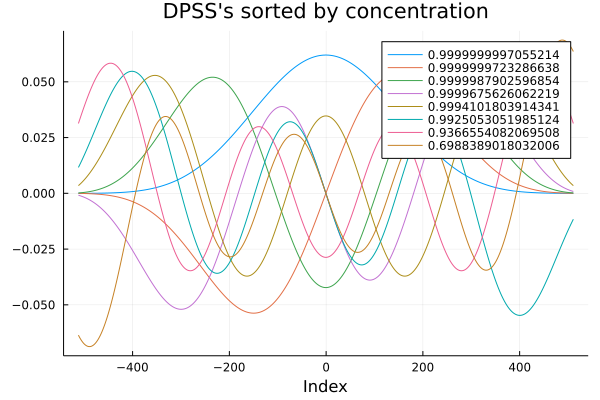

In [2]:
N     = 1024
NW    = 4.0 
K     = 8
v,lam = dpss_tapers(N, NW, K, :both)

plot(-512:511, v, label = lam', xlabel = "Index", title = "DPSS's sorted by concentration")

The very first dpss taper has the largest "concentration" in the bandwidth of interest, very close to one. Subsequent tapers are less and less concentrated. To see this, plot their Fourier transforms as below. We zero pad, as before, to interpolate structure in frequency.

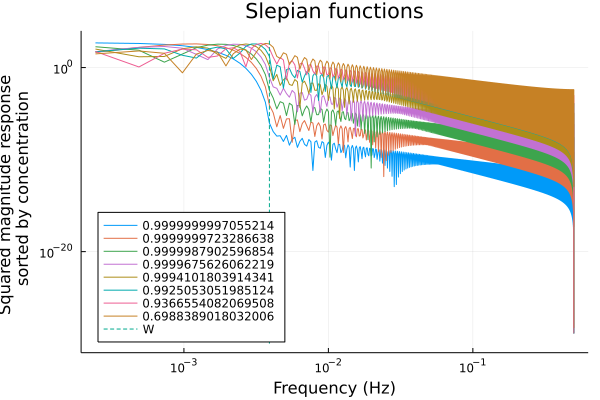

In [3]:
M        = 4*N
U        = mapreduce(x -> fft(vcat(x,zeros(M-N))), hcat, v[:,k] for k in 1:K)
halffreq = Int64(M/2+1)
freq     = range(0, 1,length = M+1)[1:halffreq]

plot(freq[2:end], abs2.(U)[2:halffreq,:], 
    label = lam', yscale = :log10, xscale = :log10,
    xlabel = "Frequency (Hz)", 
    title = "Slepian functions",
    ylabel = "Squared magnitude response \n sorted by concentration",
    legend = :bottomleft)

plot!((NW/N)*ones(2), [1e-30, 1e3], label="W", line = :dash)

One can see that the bulk of the mass under each of the curves is on the interval (-W,W). 
It is also easy to see that as the concentration, lambda, decreases, there is less mass under
the curve inside the band. Since the sequences all have unit energy, there is more mass outside
the band for larger index. Comparing with the tapers in the first plot, we see the power drop off rather quickly outside the band (-W, W) of interest. 

The bandwidth, $W$, is a tuning parameter for the multitaper method, and one adjusts the bandwidth by selecting the time-bandwidth product <tt>NW</tt> above. The number of tapers, $K$, is selected to be less than $2NW$, as the concentration rapidly drops with increasing $k$. For further reading, consult the original paper cited below. 

# References

Slepian, David. "Prolate spheroidal wave functions, Fourier analysis, and uncertainty—V: The discrete case." Bell System Technical Journal 57.5 (1978): 1371-1430.